In [1]:
from pprint import pformat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv("aggregated_results/2023-04-11.csv")
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,method,tag,runid
0,MONDO:0021034,5.270441,3.910350,2.496388,0.886327,0.659012,0.582096,humannet,disgenet,gat,useneg,1
1,MONDO:0002243,3.485505,3.444250,2.261518,0.880089,0.862430,0.729180,humannet,disgenet,gat,useneg,1
2,MONDO:0002245,2.673587,2.430942,2.881898,0.838454,0.747044,0.706527,humannet,disgenet,gat,useneg,1
3,MONDO:0001703,5.631492,3.475281,5.129240,0.956647,0.819417,0.935885,humannet,disgenet,gat,useneg,1
4,MONDO:0013099,6.576549,5.564669,5.944237,0.993888,0.917310,0.834873,humannet,disgenet,gat,useneg,1
...,...,...,...,...,...,...,...,...,...,...,...,...
43355,MONDO:0056803,4.158994,0.743917,0.520479,0.855546,0.598686,0.614428,biogrid,disgenet,gcn,noneg,5
43356,MONDO:0100284,2.658634,0.145994,0.994350,0.783241,0.507797,0.639264,biogrid,disgenet,gcn,noneg,5
43357,MONDO:0020019,4.400967,0.148995,-0.110149,0.893381,0.490108,0.441482,biogrid,disgenet,gcn,noneg,5
43358,MONDO:0021002,3.988862,2.152711,2.004616,0.870966,0.598782,0.587972,biogrid,disgenet,gcn,noneg,5


In [3]:
method_name_mapping = {
    "gat": "GAT",
    "gcn": "GCN",
    "gin": "GIN",
    "graphsage": "GraphSAGE",
}

network_name_mapping = {
    "humannet": "HumanNet",
    "biogrid": "BioGRID",
}

label_name_mapping = {
    "diseases": "DISEASES",
    "disgenet": "DisGeNET",
    "gobp": "GOBP",
}

df["network"] = df["network"].apply(network_name_mapping.get)
df["method"] = df["method"].apply(method_name_mapping.get)
df["label"] = df["label"].apply(label_name_mapping.get)

In [4]:
reduced_df = (
    df
    .groupby(["task_name", "network", "label", "method", "tag"], as_index=False)
    .mean()
    .drop(columns="runid")
)
reduced_df

,task_name,network,label,method,tag,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
0,GO:0000165,BioGRID,GOBP,GAT,noneg,4.183102,2.539172,0.062672,0.910638,0.767010,0.450885
1,GO:0000165,BioGRID,GOBP,GAT,useneg,3.769844,2.416589,0.267761,0.894346,0.742421,0.439724
2,GO:0000165,BioGRID,GOBP,GCN,noneg,4.369246,1.959091,-0.075455,0.926216,0.756061,0.379748
3,GO:0000165,BioGRID,GOBP,GCN,useneg,4.418178,1.920552,0.109783,0.911369,0.768040,0.398740
4,GO:0000165,BioGRID,GOBP,GIN,noneg,5.587779,1.798235,0.085775,0.983851,0.689341,0.439064
...,...,...,...,...,...,...,...,...,...,...,...
8667,MONDO:0700092,HumanNet,DisGeNET,GCN,useneg,3.054927,1.348134,2.326399,0.873091,0.686706,0.702345
8668,MONDO:0700092,HumanNet,DisGeNET,GIN,noneg,3.666424,1.368040,1.650015,0.927621,0.649192,0.696046
8669,MONDO:0700092,HumanNet,DisGeNET,GIN,useneg,3.626285,1.611341,1.416471,0.922574,0.671418,0.669348
8670,MONDO:0700092,HumanNet,DisGeNET,GraphSAGE,noneg,3.506140,1.693793,3.210025,0.922262,0.667521,0.703429


In [5]:
(
    reduced_df
    .groupby(["network", "label", "method", "tag"])
    .mean(numeric_only=True)
    .pivot_table(values="test_log2pr", columns=["network", "label", "method"], index="tag")
    .style.highlight_max(axis=0)
)

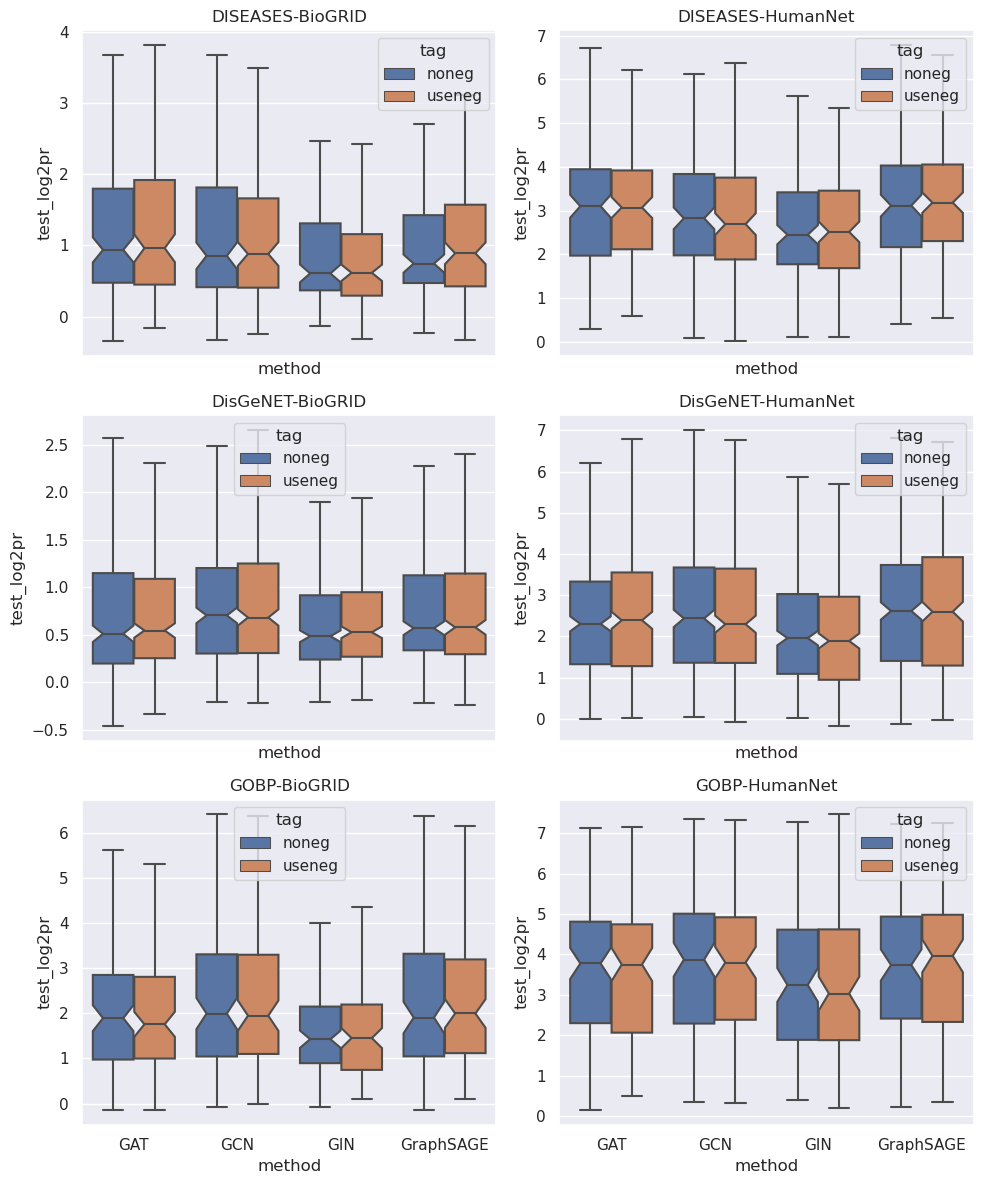

In [6]:
fig, axes = plt.subplots(
    len(label_name_mapping),
    len(network_name_mapping),
    figsize=(10, 12),
    sharex=True,
)

for ax, (names, grouped) in zip(axes.ravel(), reduced_df.groupby(["label", "network"])):
    sns.boxplot(
        data=grouped,
        x="method",
        y="test_log2pr",
        hue="tag",
        showfliers=False,
        notch=True,
        ax=ax,
    )
    ax.set_title("-".join(names))


plt.tight_layout()
plt.show()

In [7]:
tmp = reduced_df.set_index(["task_name", "network", "label", "method"])
subt_df = tmp[tmp["tag"] == "useneg"].drop(columns="tag") - tmp[tmp["tag"] == "noneg"].drop(columns="tag")
subt_df = subt_df.reset_index()
subt_df["name"] = subt_df["network"] + "-" + subt_df["label"] + "-" + subt_df["method"]
subt_df

,task_name,network,label,method,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,name
0,GO:0000165,BioGRID,GOBP,GAT,-0.413258,-0.122582,0.205090,-0.016292,-0.024589,-0.011161,BioGRID-GOBP-GAT
1,GO:0000165,BioGRID,GOBP,GCN,0.048932,-0.038539,0.185238,-0.014847,0.011978,0.018992,BioGRID-GOBP-GCN
2,GO:0000165,BioGRID,GOBP,GIN,-0.275943,0.220318,0.576241,-0.010576,-0.023939,0.107081,BioGRID-GOBP-GIN
3,GO:0000165,BioGRID,GOBP,GraphSAGE,-0.549050,0.468026,0.262222,-0.009600,0.061192,0.027813,BioGRID-GOBP-GraphSAGE
4,GO:0000165,HumanNet,GOBP,GAT,0.610563,-0.184057,0.296581,0.008289,0.006612,-0.012511,HumanNet-GOBP-GAT
...,...,...,...,...,...,...,...,...,...,...,...
4331,MONDO:0700092,HumanNet,DISEASES,GraphSAGE,0.015080,-0.001978,-0.067672,0.000194,-0.009883,-0.019062,HumanNet-DISEASES-GraphSAGE
4332,MONDO:0700092,HumanNet,DisGeNET,GAT,-0.126936,-0.333534,-0.272553,0.002996,-0.007556,0.037453,HumanNet-DisGeNET-GAT
4333,MONDO:0700092,HumanNet,DisGeNET,GCN,0.114736,-0.237763,-0.041453,0.005003,-0.010904,-0.012136,HumanNet-DisGeNET-GCN
4334,MONDO:0700092,HumanNet,DisGeNET,GIN,-0.040139,0.243301,-0.233544,-0.005047,0.022226,-0.026697,HumanNet-DisGeNET-GIN


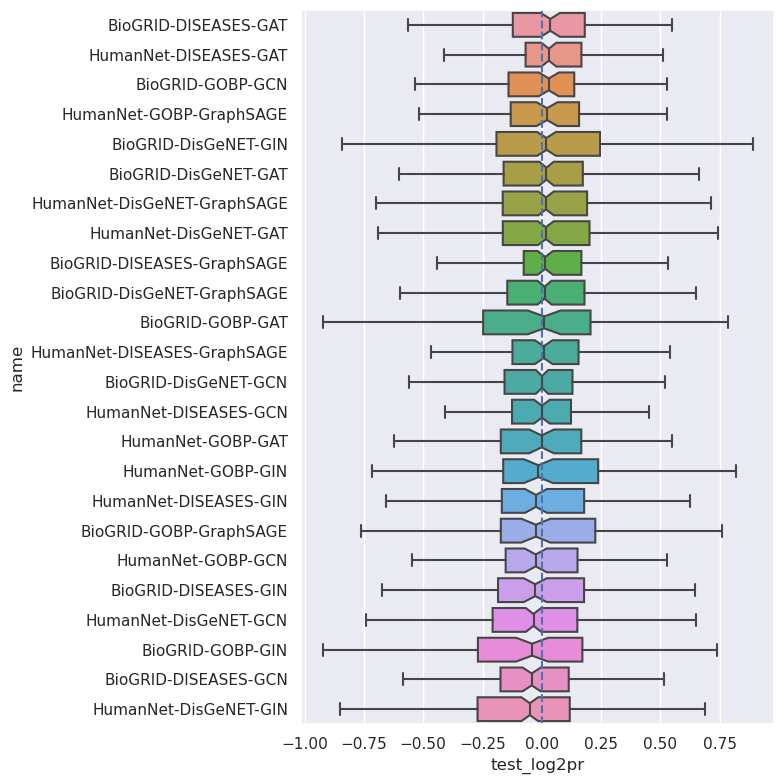

In [8]:
plt.figure(figsize=(8, 8))
fig = sns.boxplot(
    data=subt_df,
    y="name",
    x="test_log2pr",
    order=(
        subt_df
        .groupby("name")
        .median(numeric_only=True)
        .sort_values("test_log2pr", ascending=False)
        .index
        .tolist()
    ),
    showfliers=False,
    notch=True,
)
fig.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()